<h1 align="center">Logistic Regression</h1> 

В области машинного обучения одним из самых популярных методов бинарной классификации (предсказываем один из двух классов для каждого объекта) является логистическая регрессия, лог регрессия настраивается с помощью метода максимального правдоподобия, который приводит к следующей задаче оптимизации:

$$ L(w, X, y) = \sum_{i = 0}^{N} log (1 + exp(-y_ix_i^Tw)) + \frac{1}{2} ||w||^2-> \min_w$$
$$X \in R^{N \times M}, x \in R^{M}, w \in R^{M}, y \in \{-1, 1\}^N$$

когда мы решили задачу оптимизации (нашли $w$), мы принимаем решение о том, к какому классу относится объект по правилу $y(x) = sign(x^Tw)$. В данной части вам необходимо применить методы линейной алгебры для решения этой задачи. 

<h1 align="center">Check Questions</h1> 

Ответе на вопросы своими словами, если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1**: Чем лог-регрессия отличается от svm?

<Ответ>

**Вопрос 2**: Почему считается что регуляризатор мешает переобучаться? Что такое переобучение?

<Ответ>

**Вопрос 3**: Почему лог-регрессия это классификатор?

<Ответ>

### Лог-регрессия своими руками

In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Для тестирования правильности вычисления сгенерируем аргументы, небольшого размера
w, X, y = np.random.random(4), np.random.random((5, 4)), 2*(np.random.randint(0, 2, 5)-0.5)

### Шаг 1

Запрограммируйте вычисление функции L, используйте только матричные операции (внутри не должно быть циклов -- циклы спрятанны в матричные умножения).

**Замечание**: Нигде в промежуточных вычислениях не стоит вычислять значение $exp(−y_ix^Tw)$, иначе может произойти переполнение. Вместо этого следует напрямую вычислять необходимые величины с помощью специализированных для этого функций: `np.logaddexp` для `ln(1 + exp(·))` и `sp.special.expit` для `1/(1 + exp(·))`.

In [3]:
def logistic(w, X, y):
    """
        logistic(w, X, y) вычисляет функцию качества лог регрессии L(w, X, y)
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        funcw: np.float 
    """
    funcw = np.logaddexp(0,-np.dot(y,np.dot(X,w))) + 0.5*np.dot(w,w)
    return funcw

In [4]:
isinstance(logistic(w, X, y), float) # Результат число, этож функция потерь.

True

### Шаг 2

Найдите градиент функции $\nabla_w L(w, X, y)$, запишите в терминах матричных операций, эффективно запрограммируйте вычисленный градиент.

In [5]:
def logistic_grad(w, X, y):
    """
        logistic_grad(w, X, y) вычисляет градиент функции качества лог регрессии dL(w, X, y)/dw
        
        w: np.array размера (M,)
        X: np.array размера (N, M)
        y: np.array размера (M,)
        
        gradw: np.array размера (M,)
    """
    gradw = np.zeros_like(w) # Вычислите градиент функции dL/dw
    gradw = -np.dot(y,X)*special.expit(-np.dot(y,np.dot(X,w))) + w
    return gradw

In [6]:
assert(logistic_grad(w, X, y).shape == w.shape) # Результат вектор, этож градиент.

### Шаг 3

Очень часто при подсчёте градиента допускаются ошибки, проверьте правильность реализации подсчёта градиента с помощью функции scipy.optimize.check_grad, ошибка должна быть ~ 1e-8 или меньше.

In [7]:
from scipy.optimize import check_grad

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)

print('error = %s' % check_grad(func, grad, w))

error = 5.00182083559e-08


### Шаг 4

А теперь найдем $w$ используя метод оптимизации optimize.fmin_l_bfgs_b применим к реальным данным.

In [8]:
from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score as acc

X, y = make_classification(n_features=20, n_informative=3, n_classes=2, )
y = 2*(y - 0.5)
X_train, X_test, y_train, y_test = train_test_split(X, y)

/home/german/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
from scipy import optimize

w = np.zeros_like(X[0]) # Начальное значение параметров w
func = lambda w: logistic(w, X_train, y_train)
grad = lambda w: logistic_grad(w, X_train, y_train)

w = optimize.fmin_l_bfgs_b(func, w, grad)[0] # используйте optimize.fmin_l_bfgs_b

In [10]:
print('train acc = ', acc(np.sign(X_train.dot(w)), y_train), 'test acc = %s' % acc(np.sign(X_test.dot(w)), y_test))

train acc =  0.773333333333 test acc = 0.88


### Шаг 5, Давайте визуализируем наш метод, а то хочется глазами посмотреть

In [11]:
from scipy import optimize

def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1;
    return X_

def visualize(X, y, w, loss, n_iter, h=0.01):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    plt.clf()
    Z = classify(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap='rainbow', alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
def viz_opt(func, gradf, X, y, n_iter=10, lr=1e-3):
    a = None
    loss1 = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    ind = np.arange(X.shape[0])
    
    w = np.zeros(X.shape[1])
    
    for i in range(n_iter):        
        loss1[i] += func(w)
        visualize(X, y, w, loss1, n_iter)
        
        fvalx, gradx = func(w), grad(w)
        w = optimize.fmin_l_bfgs_b(func, w, approx_grad=grad)[0]
        
    visualize(X, y, w, loss1, n_iter)
    
    q = plt.clf()
    plt.show()

In [12]:
from sklearn.datasets import make_moons, make_circles, make_classification

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2)
X += np.random.random(X.shape)

datasets = [make_moons(noise=0.1), make_circles(noise=0.1, factor=0.5), (X, y)]

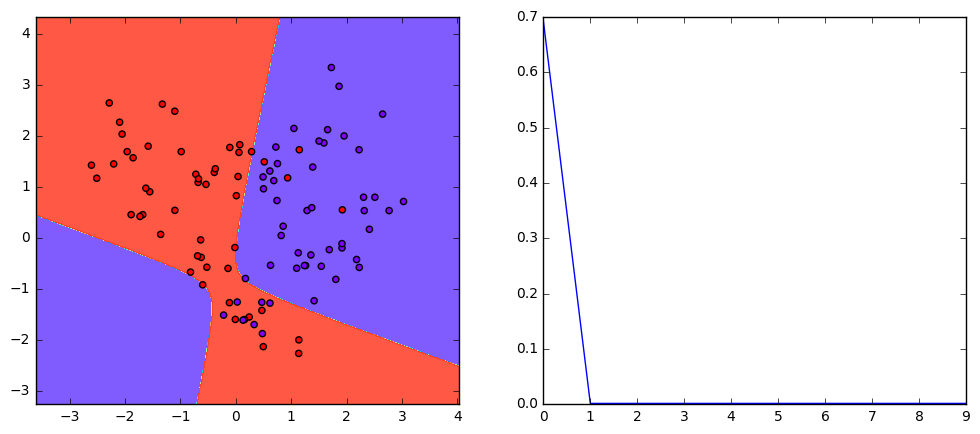

In [13]:
from IPython import display

def classify(X, w):
    return np.sign(1.0 / (1.0 + np.exp(-X.dot(w))) - 0.5)

func = lambda w: logistic(w, X, y)
grad = lambda w: logistic_grad(w, X, y)

for X, y in datasets:
    X, y = expand(X), -2*(y-0.5)
    a = viz_opt(func, grad, X, y) 

### Шаг 6 Сдать ДЗ

In [14]:
X = np.array([
    [ 0.11276959,  0.44971499,  0.9923867 ,  0.89212961],
    [ 0.82695301,  0.30505746,  0.40539034,  0.68335903],
    [ 0.98938714,  0.34498564,  0.36259562,  0.46714136],
    [ 0.46335495,  0.62208345,  0.95386954,  0.41550278],
    [ 0.91471692,  0.69649708,  0.82290076,  0.86441013]])

w = np.array([ 0.45920206,  0.24257981,  0.96715112,  0.21759684])
y = np.array([-1., -1., -1., -1.,  1.])

In [15]:
# Заполните форму https://goo.gl/forms/nRSQuIk8olbmVRIi1 

print('значение функции потерь %.2f'   % logistic(w, X, y))
print('значение суммы градиентов %.2f' % logistic_grad(w, X, y).sum())

значение функции потерь 3.77
значение суммы градиентов 7.62
